# Week 1: Feature Detection & Matching for Multiple Image Pairs

This notebook implements the first milestone of the CS436 project: **Setup & Feature Matching**.


In [1]:
# Import libraries
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os
import sys

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

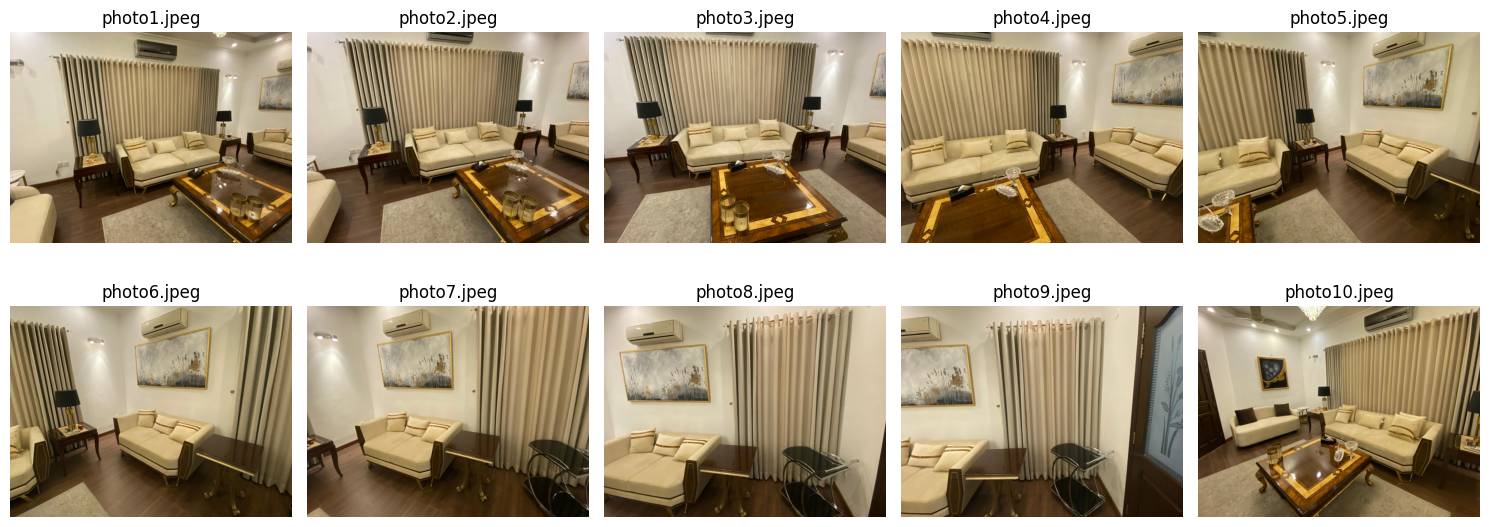

In [8]:
# --- Display first 10 photos in a grid ---
import matplotlib.pyplot as plt

data_dir = os.path.join(module_path, 'data2')
grid_names = [f'photo{i}.jpeg' for i in range(1, 11)]
grid_paths = [os.path.join(data_dir, name) for name in grid_names]

fig, axes = plt.subplots(2, 5, figsize=(15, 6))
for i, ax in enumerate(axes.flat):
    img = cv2.imread(grid_paths[i])
    if img is not None:
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        ax.imshow(img_rgb)
        ax.set_title(f'photo{i+1}.jpeg')
    ax.axis('off')
plt.tight_layout()
plt.show()


In [2]:
# Load Images

IMAGE_NAMES = ['photo4.jpeg', 'photo5.jpeg', 'photo6.jpeg', 'photo7.jpeg', 'photo8.jpeg']

data_dir = os.path.join(module_path, 'data2')
image_paths = [os.path.join(data_dir, name) for name in IMAGE_NAMES]

for i, name in enumerate(IMAGE_NAMES):
    print(f"  {i}: {name}")

# load and preprocess image
def load_and_preprocess_image(img_path, target_size=None):
    """Load image and optionally resize to target size."""
    img = cv2.imread(img_path, cv2.IMREAD_COLOR)
    if img is None:
        raise ValueError(f"Could not load image: {img_path}")
    
    if target_size is not None:
        img = cv2.resize(img, target_size)
    
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    return img_rgb, gray

images_rgb = []
images_gray = []


temp_imgs = []
for path in image_paths:
    img = cv2.imread(path, cv2.IMREAD_COLOR)
    if img is None:
        raise ValueError(f"Could not load: {path}")
    temp_imgs.append(img)

# find minimum dimensions
min_height = min(img.shape[0] for img in temp_imgs)
min_width = min(img.shape[1] for img in temp_imgs)
target_size = (min_width, min_height)

# load and resize to common size
for path in image_paths:
    img_rgb, gray = load_and_preprocess_image(path, target_size)
    images_rgb.append(img_rgb)
    images_gray.append(gray)

print(f"Loaded {len(images_rgb)} images successfully!")

  0: photo4.jpeg
  1: photo5.jpeg
  2: photo6.jpeg
  3: photo7.jpeg
  4: photo8.jpeg
Loaded 5 images successfully!


In [3]:
# Initialize SIFT detector with tunable parameters
nfeatures = 8000         
contrastThreshold = 0.02  
edgeThreshold = 10      
sigma = 1.6               

sift = cv2.SIFT_create(
    nfeatures=nfeatures,
    contrastThreshold=contrastThreshold,
    edgeThreshold=edgeThreshold,
    sigma=sigma
)
print(f"SIFT detector initialized:")

SIFT detector initialized:


In [4]:
# Detect features in all images

print("\nDetecting features in all images...")
all_keypoints = []
all_descriptors = []

for i, (gray, name) in enumerate(zip(images_gray, IMAGE_NAMES)):
    kp, des = sift.detectAndCompute(gray, None)
    all_keypoints.append(kp)
    all_descriptors.append(des)
    print(f"  {name}: {len(kp)} keypoints")


Detecting features in all images...
  photo4.jpeg: 4893 keypoints
  photo5.jpeg: 4507 keypoints
  photo6.jpeg: 3761 keypoints
  photo7.jpeg: 2715 keypoints
  photo8.jpeg: 2733 keypoints


In [5]:
# match and visualize a pair

def match_and_visualize_pair(idx1, idx2, ratio_thresh=0.75, num_display=50, use_ransac=False):

    name1 = IMAGE_NAMES[idx1]
    name2 = IMAGE_NAMES[idx2]
    
    print(f"\n{'='*60}")
    print(f"Matching: {name1} <-> {name2}")
    print(f"{'='*60}")
    
    # Get keypoints and descriptors
    kp1, des1 = all_keypoints[idx1], all_descriptors[idx1]
    kp2, des2 = all_keypoints[idx2], all_descriptors[idx2]
    
    # Match using BFMatcher
    bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=False)
    matches = bf.knnMatch(des1, des2, k=2)
    
    # Apply Lowe's ratio test
    good_matches = []
    for match_pair in matches:
        if len(match_pair) == 2:
            m, n = match_pair
            if m.distance < ratio_thresh * n.distance:
                good_matches.append(m)
    
    
    if use_ransac and len(good_matches) >= 10:
        pts1_temp = np.float32([kp1[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
        pts2_temp = np.float32([kp2[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)
        
        # Find homography with RANSAC
        H, mask = cv2.findHomography(pts1_temp, pts2_temp, cv2.RANSAC, 5.0)
        
        if mask is not None:
            good_matches = [m for m, inlier in zip(good_matches, mask.ravel()) if inlier]
    
    good_matches = sorted(good_matches, key=lambda x: x.distance)

    
    # extract matched points
    pts1 = np.float32([kp1[m.queryIdx].pt for m in good_matches])
    pts2 = np.float32([kp2[m.trainIdx].pt for m in good_matches])
    
    # visualize matches
    matches_to_draw = good_matches[:num_display]
    img_matches = cv2.drawMatches(
        images_rgb[idx1], kp1, 
        images_rgb[idx2], kp2, 
        matches_to_draw, None,
        flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS,
        matchColor=(0, 255, 0),
        singlePointColor=(255, 0, 0)
    )
    
    # display
    plt.figure(figsize=(18, 8))
    plt.imshow(img_matches)
    plt.title(f'{name1} <-> {name2}: {len(good_matches)} matches (showing {min(num_display, len(good_matches))})')
    plt.axis('off')
    plt.tight_layout()
    plt.show()
    
    return pts1, pts2, good_matches

MATCHING ALL CONSECUTIVE PAIRS

Matching: photo4.jpeg <-> photo5.jpeg


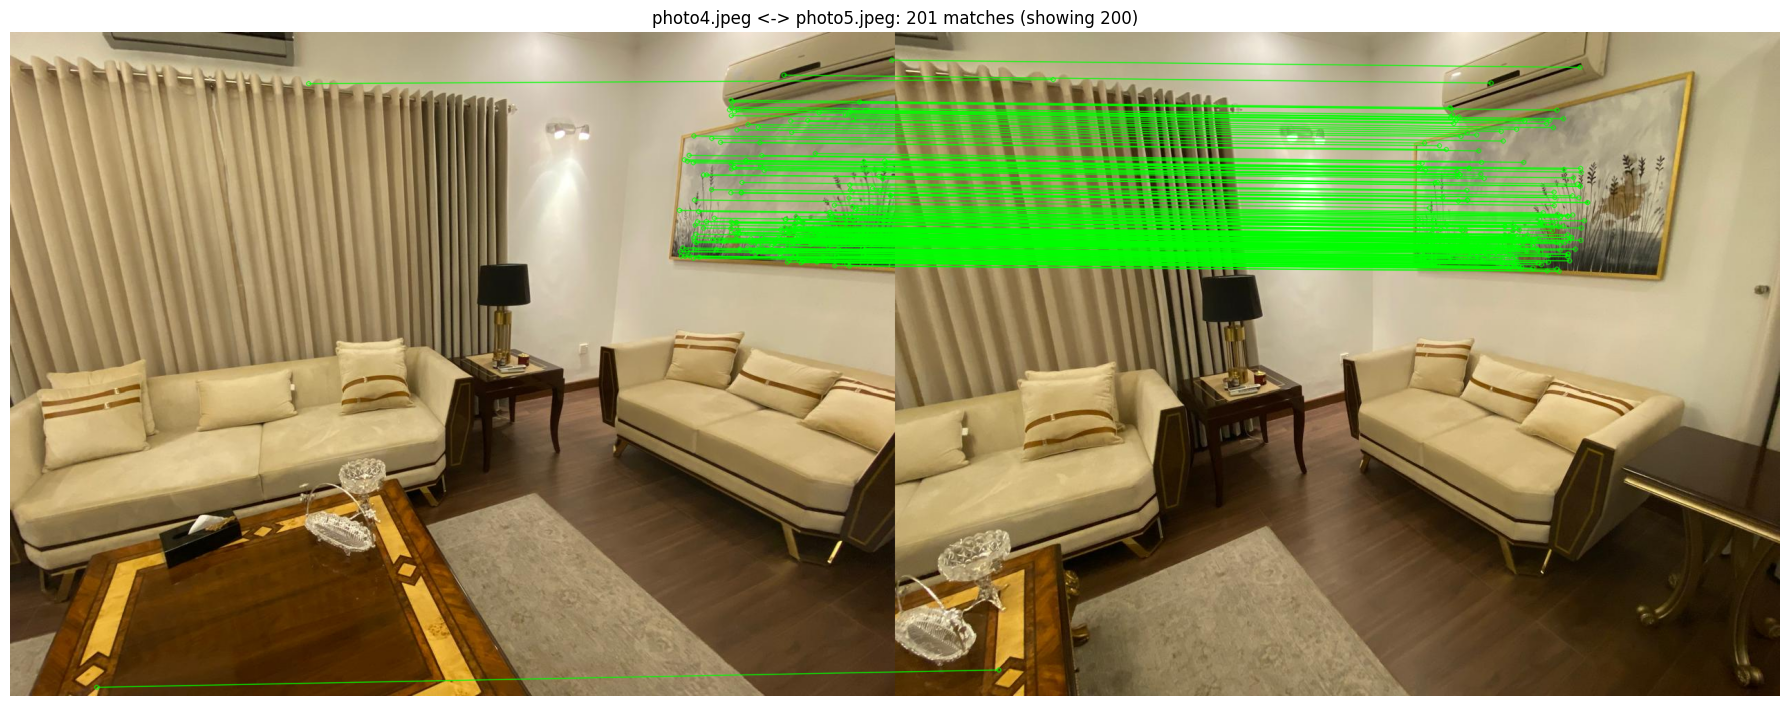


Matching: photo5.jpeg <-> photo6.jpeg


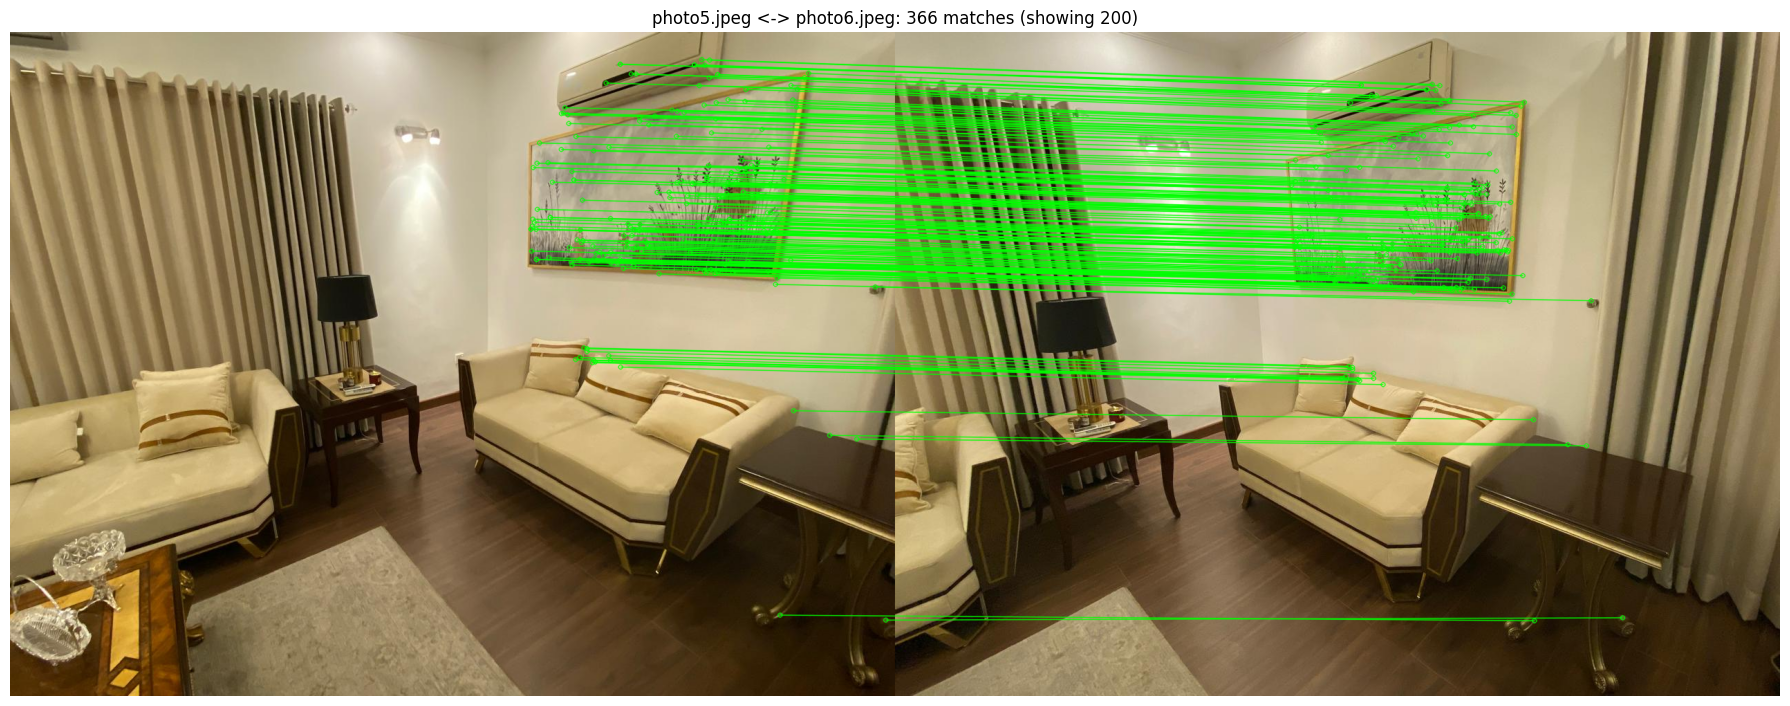


Matching: photo6.jpeg <-> photo7.jpeg


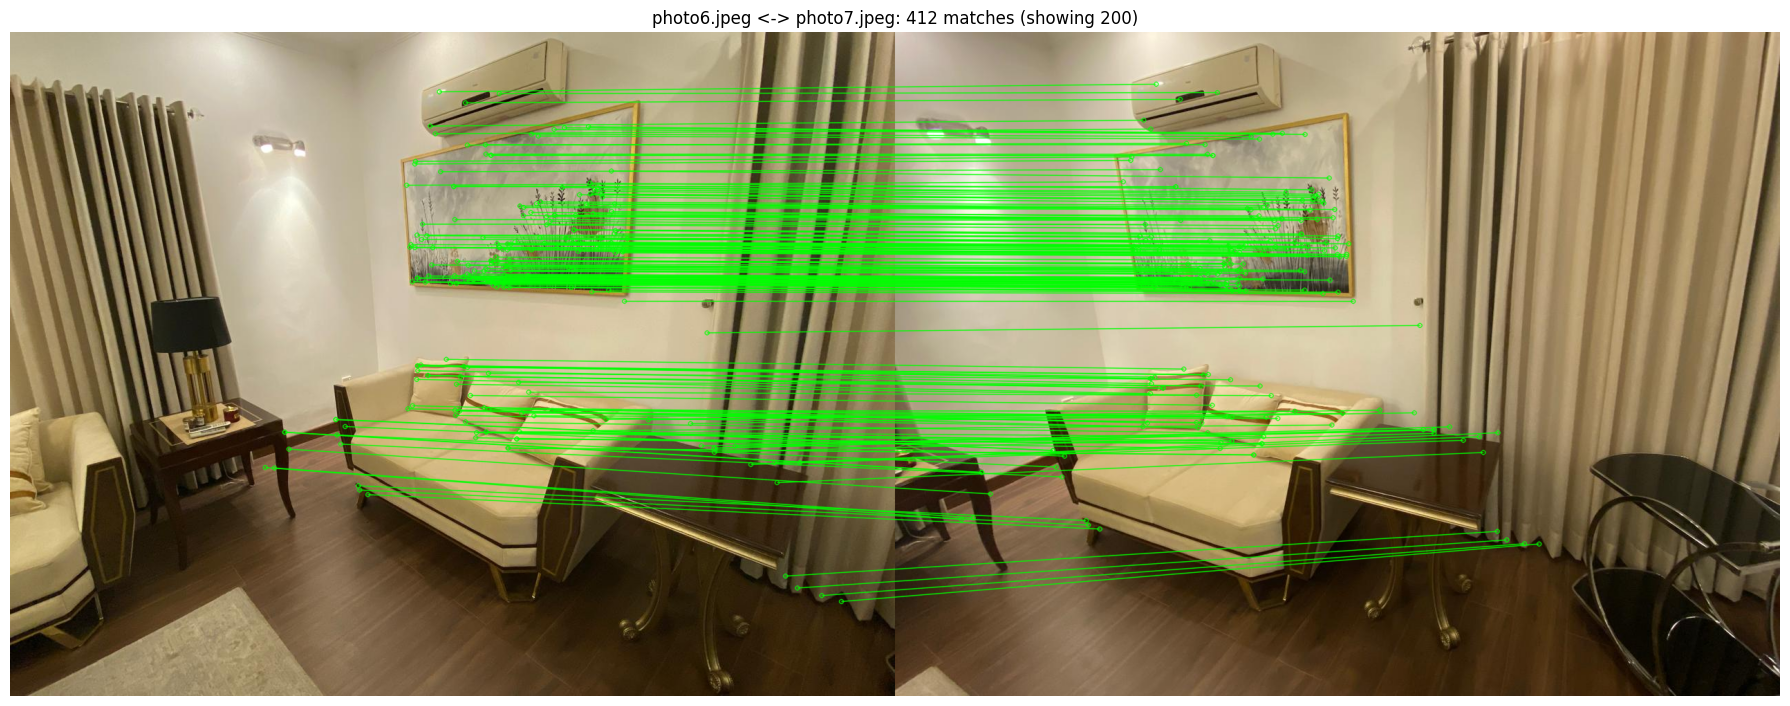


Matching: photo7.jpeg <-> photo8.jpeg


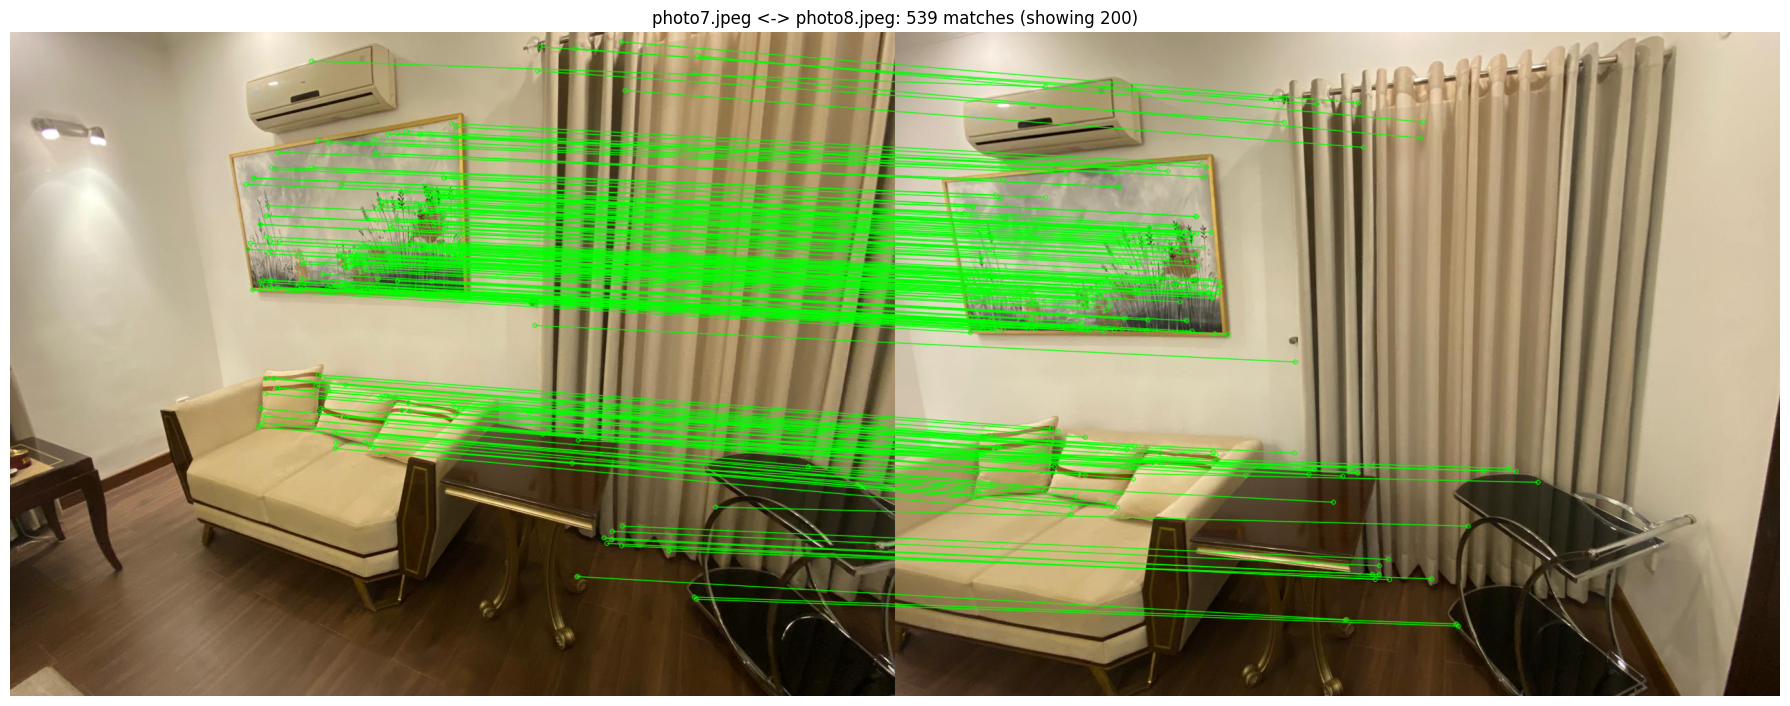

In [6]:
# Match all consecutive pairs

RATIO_THRESH = 0.75
USE_RANSAC = True    
NUM_DISPLAY = 200  

print("MATCHING ALL CONSECUTIVE PAIRS")

all_matches_data = []

for i in range(len(IMAGE_NAMES) - 1):
    pts1, pts2, matches = match_and_visualize_pair(
        i, i+1, 
        ratio_thresh=RATIO_THRESH, 
        num_display=NUM_DISPLAY,
        use_ransac=USE_RANSAC
    )
    all_matches_data.append({
        'pair': (i, i+1),
        'names': (IMAGE_NAMES[i], IMAGE_NAMES[i+1]),
        'pts1': pts1,
        'pts2': pts2,
        'matches': matches,
        'num_matches': len(matches)
    })